# Evaluation OpenAI as an annotator to replace the expert

In [1]:
import pandas as pd
import time
from tqdm import tqdm
import os
import re
import string
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate import meteor_score
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
from openai import OpenAI
from bert_score import BERTScorer

from llama_index.llms import OpenAI
from openai import OpenAI
import json
import pandas as pd
from langchain import PromptTemplate
from tqdm import tqdm


file_name = "exp_result_Meta-Llama-3-70B-Instruct_20240531194751_952843.csv"
foler_path = "Paper Experiment Results/New_filtered/creativity"

output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
`AnnotionFormat` is deprecated and will be removed in v4.38. Please use `transformers.image_utils.AnnotationFormat` instead.
2024-06-07 21:13:30.088981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
with open(
    "Paper Experiment Results/New_filtered/creativity/creativity_eval-main/creativity_eval-main/tests/ttcw_all_tests.json",
    "r",
) as f:
    tests = json.load(f)


# Based on the create_eval code
def full_prompt2context(full_prompt):
    lines = full_prompt.strip().split("\n")
    kept1 = "\n".join(lines[:-1]).strip().split("\n")
    kept2 = kept1[:-1]
    return "\n".join(kept2).strip()


for test in tests:
    test["expanded_context"] = full_prompt2context(test["full_prompt"])


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def extract_final_response(response, prompt):
    return response[len(prompt) :]


evaluation_df = pd.DataFrame(tests)

In [3]:
evaluate_prompt = """You are given a creative short-story. Read it carefully. You are then given some background about specific aspects of creative writing, as well as a binary (Yes/No) question. Your objective is to use the background information to answer the question about the story. Start your answer with Yes or No. You can optionally then provide a short explanation for your answer.

==========
Story:
{story}
==========
Background:
{background}

==========
Question: {question}

Remember to start your answer with Yes or No. You can optionally then provide a short explanation for your answer.
"""

evaluate_prompt_template = PromptTemplate.from_template(evaluate_prompt)

In [4]:
import pandas as pd

stories_generated_df = pd.read_csv(input_path)

if "story_generated" in stories_generated_df.columns:
    print("Detected new version results")
    stories_generated_df["pure_response"] = stories_generated_df["story_generated"]
else:
    print("Detected old version results")
    stories_generated_df["pure_response"] = stories_generated_df["generated_response"]

cartesian_product_df = pd.merge(
    evaluation_df.assign(key=0),
    stories_generated_df.assign(key=0),
    how="outer",
    on="key",
).drop("key", axis=1)

print("cartesian_product rows:", cartesian_product_df.shape[0])
print("cartesian_product columns:", cartesian_product_df.columns)

cartesian_product_df["formatted_prompt"] = cartesian_product_df.apply(
    lambda row: evaluate_prompt_template.format(
        story=row["pure_response"],
        background=row["expanded_context"],
        question=row["question"],
    ),
    axis=1,
)

Detected new version results
cartesian_product rows: 1176
cartesian_product columns: Index(['ttcw_idx', 'torrance_dimension', 'category', 'question', 'full_prompt',
       'expanded_context', 'Unnamed: 0', 'Temperature', 'story_idx',
       'story_name', 'plot', 'content', 'word_count', 'initial_prompt',
       'llama2_chat_initial_prompt', 'mixtral_instruct_initial_prompt',
       'llama3_chat_initial_prompt', 'llama2_chat_initial_prompt_recurrent',
       'mixtral_instruct_initial_prompt_recurrent',
       'llama3_chat_initial_prompt_recurrent', 'generated_response',
       'story_generated', 'timestamp', 'elapsed_time', 'temperature', 'model',
       'repetition_times', 'pure_response'],
      dtype='object')


In [5]:
import os

if os.path.exists(output_path):
    data_evaluated = pd.read_csv(output_path)
    last_idx = data_evaluated.shape[0]
else:
    last_idx = 0

generated_responses = []
client = OpenAI(api_key=api_key)
with tqdm(total=len(cartesian_product_df)) as pbar:
    for index, row in cartesian_product_df.iterrows():
        if index < last_idx:
            pbar.update(1)
            continue
        response = (
            client.chat.completions.create(
                model="gpt-4-turbo",
                messages=[
                    {"role": "user", "content": row["formatted_prompt"]},
                ],
            )
            .choices[0]
            .message
        ).content
        generated_responses.append(response)
        updated_row = row.copy()
        updated_row["OpenAI_response"] = response
        updated_dataframe = pd.DataFrame([updated_row])
        pbar.update(1)
        if not os.path.exists(output_path):
            updated_dataframe.to_csv(output_path, index=False, mode="w", header=True)
        else:
            updated_dataframe.to_csv(output_path, index=False, mode="a", header=False)

100%|██████████| 1176/1176 [00:00<00:00, 60609.99it/s]


In [ ]:
def label_function(x):
    if str(x).startswith("Yes"):
        return "yes"
    elif str(x).startswith("No"):
        return "no"
    else:
        return "Error"


data_evaluated["label"] = data_evaluated["OpenAI_response"].apply(label_function)

# Analysis Integrated

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/creativity"
output_photo_name = f"CT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)

In [2]:
def label_function(x):
    if str(x).startswith("Yes"):
        return True
    elif str(x).startswith("No"):
        return False
    else:
        return None


df["label"] = df["OpenAI_response"].apply(label_function)
df = df[~df["label"].isna()]
df = df[df["Temperature"] != "temperature"]
df["Temperature"] = df["Temperature"].astype(float).round(1)

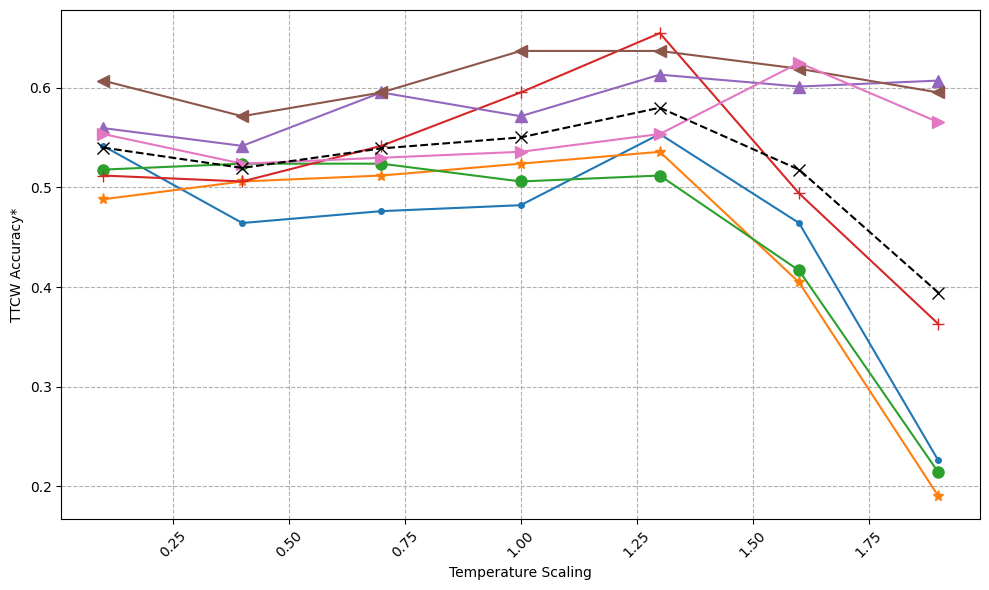

In [3]:
grouped_data = df.groupby(["model", "Temperature"])["label"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["label"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("TTCW Accuracy*")
# plt.title(
#     "Creativity\n Mean TTCW Accuracy with Temperature Across Models - Creativity Eval"
# )
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [5]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    accuracy = model_data["label"].values
    corr, p_value = spearmanr(temperatures, accuracy)

    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params

    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


results_df = pd.DataFrame(results)


# for model in models:
#     # print(f"Model: {model}")
#     print(f"{correlations[model]}")
# print()
# for model in models:
#     print(f"{p_values[model]}")

# for model in models:
#     print(f"Model: {model}")
#     print(f"Kendall correlation: {correlations[model]}")
#     print(f"p-value: {p_values[model]}")
#     print(f"OLS summary:")
#     print(ols_results[model].summary())
#     print()

results_df.to_csv("output.csv")